In [1]:
# pip install
#!pip install -r requirements.txt

# Imports
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from pprint import pprint
import time

# Module imports
from periodic_table import *
from utils import *
print("Imported all.")

Imported all.


# Open data files

In [2]:
# original, NC, FTFP
physic_model = "NC"

# Open propmt TPC data file
file_dir = f"./assets/{physic_model}/A_Z_count-TPC_prompt.txt"
columns = ["Mass Number", "Atomic Number", "Counts"]
df_TPC_prompt = open_data(file_dir, columns)
# Add in isotope data
add_isotope_data(df_TPC_prompt)
# Reorder columns
df_TPC_prompt = df_TPC_prompt[["Iso Symbol","Atomic Number","Mass Number","Counts","Production Yield","Stable","Half Life (s)","Decay Modes (m, b, q MeV)","Max Q-Value","Plot Colour",]]

Considered delayed if created at time > 20 microseconds

In [3]:
# Open delayed TPC data file
file_dir = f"./assets/{physic_model}/A_Z_count-TPC_delayed.txt"
columns = ["Mass Number", "Atomic Number", "Counts"]
df_TPC_delayed = open_data(file_dir, columns)
# Add in isotope data
add_isotope_data(df_TPC_delayed)
# Reorder columns
df_TPC_delayed = df_TPC_delayed[["Iso Symbol","Atomic Number","Mass Number","Counts","Production Yield","Stable","Half Life (s)","Decay Modes (m, b, q MeV)","Max Q-Value","Plot Colour",]]

In [4]:
# Open buffer data file
file_dir = f"./assets/{physic_model}/A_Z_count-buffers.txt"
columns = ["Mass Number", "Atomic Number", "Counts"]
df_buffers = open_data(file_dir, columns)
# Add in isotope data
add_isotope_data(df_buffers)
# Reorder columns
df_buffers = df_buffers[["Iso Symbol","Atomic Number","Mass Number","Counts","Production Yield","Stable","Half Life (s)","Decay Modes (m, b, q MeV)","Max Q-Value","Plot Colour",]]

# Preprocessing

### Add Production (/yr)

In [5]:
# Simulation length = years * nanoseconds
year_in_nano = (3.154 * 10**16)
year_in_sec = (3.154 * 10**7)
day_in_sec = 86400
### VARY THIS ###
muon_no = 10 ** 8
muon_flux = 3.447 * 10 ** 6 # per year
sim_length = muon_no / muon_flux
print(f"Simulation length (yr): {sim_length}")

df_buffers["Production (/yr)"] = df_buffers["Counts"] / sim_length
df_TPC_prompt["Production (/yr)"] = df_TPC_prompt["Counts"] / sim_length
df_TPC_delayed["Production (/yr)"] = df_TPC_delayed["Counts"] / sim_length
# Yield per muon
df_buffers["Yield per Muon (/yr)"] = df_buffers["Counts"] / muon_no
df_TPC_prompt["Yield per Muon (/yr)"] = df_TPC_prompt["Counts"] / muon_no
df_TPC_delayed["Yield per Muon (/yr)"] = df_TPC_delayed["Counts"] / muon_no

Simulation length (yr): 29.01073397156948


### Create unstable dfs

In [6]:
unstable_buffers = df_buffers[df_buffers["Stable"] == False]
unstable_TPC_prompt = df_TPC_prompt[df_TPC_prompt["Stable"] == False]
unstable_TPC_delayed = df_TPC_delayed[df_TPC_delayed["Stable"] == False]

### Print Information

In [7]:
print("Buffers:")
print(f"No: {len(df_buffers)}")
print(f"Total Counts: {df_buffers['Counts'].sum()}")
print(f"Total Production (yr): {df_buffers['Production (/yr)'].sum()}")
print(f"Number of stable isotopes: {len(df_buffers) - len(unstable_buffers)}")
print(f"Number of unstable isotopes: {len(unstable_buffers)}")
print()
print("TPC Prompt:")
print(f"No: {len(df_TPC_prompt)}")
print(f"Total Counts: {df_TPC_prompt['Counts'].sum()}")
print(f"Total Production (yr): {df_TPC_prompt['Production (/yr)'].sum()}")
print(f"Number of stable isotopes: {len(df_TPC_prompt) - len(unstable_TPC_prompt)}")
print(f"Number of unstable isotopes: {len(unstable_TPC_prompt)}")
print()
print("TPC Delayed:")
print(f"No: {len(df_TPC_delayed)}")
print(f"Total Counts: {df_TPC_delayed['Counts'].sum()}")
print(f"Total Production (yr): {df_TPC_delayed['Production (/yr)'].sum()}")
print(f"Number of stable isotopes: {len(df_TPC_delayed) - len(unstable_TPC_delayed)}")
print(f"Number of unstable isotopes: {len(unstable_TPC_delayed)}")

Buffers:
No: 181
Total Counts: 191335006
Total Production (yr): 6595317.656820001
Number of stable isotopes: 39
Number of unstable isotopes: 142

TPC Prompt:
No: 170
Total Counts: 79525683
Total Production (yr): 2741250.293009999
Number of stable isotopes: 39
Number of unstable isotopes: 131

TPC Delayed:
No: 93
Total Counts: 18009353
Total Production (yr): 620782.39791
Number of stable isotopes: 39
Number of unstable isotopes: 54


### Filter by realistic half-life

Find max and min half lifes

In [8]:
print("Buffers:")
print(f"Min half life (sec): {unstable_buffers['Half Life (s)'].min()}\nMax half life (day): {unstable_buffers['Half Life (s)'].max() / day_in_sec}")
print("TPC Prompt:")
print(f"Min half life (sec): {unstable_TPC_prompt['Half Life (s)'].min()}\nMax half life (day): {unstable_TPC_prompt['Half Life (s)'].max() / day_in_sec}")
print("TPC Delayed:")
print(f"Min half life (sec): {unstable_TPC_delayed['Half Life (s)'].min()}\nMax half life (day): {unstable_TPC_delayed['Half Life (s)'].max() / day_in_sec}")

Buffers:
Min half life (sec): 0.0
Max half life (day): 1.0960648148148148e+24
TPC Prompt:
Min half life (sec): 0.0
Max half life (day): 1.0960648148148148e+24
TPC Delayed:
Min half life (sec): 7.91e-22
Max half life (day): 1.0960648148148148e+24


In [9]:
# year * days * seconds
upper_lim = 1 * 356 * day_in_sec
print(f"Removing isotopes with decay time longer than: {upper_lim}s")
unstable_buffers_rem = unstable_buffers[unstable_buffers["Half Life (s)"] > upper_lim].sort_values("Half Life (s)")
unstable_TPC_prompt_rem = unstable_TPC_prompt[unstable_TPC_prompt["Half Life (s)"] > upper_lim].sort_values("Half Life (s)")
unstable_TPC_delayed_rem = unstable_TPC_delayed[unstable_TPC_delayed["Half Life (s)"] > upper_lim].sort_values("Half Life (s)")
print("Removed isotopes:")
print(unstable_buffers_rem)
print(unstable_TPC_prompt_rem)
print(unstable_TPC_delayed_rem)

unstable_buffers = unstable_buffers[unstable_buffers["Half Life (s)"] < upper_lim].sort_values("Half Life (s)")
unstable_TPC_prompt = unstable_TPC_prompt[unstable_TPC_prompt["Half Life (s)"] < upper_lim].sort_values("Half Life (s)")
unstable_TPC_delayed = unstable_TPC_delayed[unstable_TPC_delayed["Half Life (s)"] < upper_lim].sort_values("Half Life (s)")
print(f"Difference:")
print(f"Buffers: {len(unstable_buffers_rem)}")
print(f"TPC Prompt: {len(unstable_TPC_prompt_rem)}")
print(f"TPC Delayed: {len(unstable_TPC_delayed_rem)}")

Removing isotopes with decay time longer than: 30758400s
Removed isotopes:
    Iso Symbol Atomic Number Mass Number   Counts  Production Yield  Stable  \
71    Na 11-22            11          22     2262      1.182220e-05   False   
174   Ar 18-42            18          42       26      1.358873e-07   False   
119   Si 14-32            14          32    10303      5.384796e-05   False   
163   Ar 18-39            18          39  2777990      1.451898e-02   False   
37      C 6-14             6          14     1012      5.289152e-06   False   
173   Ca 20-41            20          41       10      5.226435e-08   False   
146   Cl 17-36            17          36   101350      5.296992e-04   False   
90    Al 13-26            13          26     3348      1.749810e-05   False   
22     Be 4-10             4          10      586      3.062691e-06   False   
169    K 19-40            19          40     5586      2.919487e-05   False   
170   Ca 20-40            20          40     5000      2

### Add beta decay energy columns

In [10]:
# https://nds.iaea.org/relnsd/vcharthtml/api_v0_notebook.html
# https://nds.iaea.org/relnsd/vcharthtml/api_v0_guide.html#gamma
# https://nds.iaea.org/relnsd/vcharthtml/VChartHTML.html
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
import time

# the service URL
livechart = "https://nds.iaea.org/relnsd/v0/data?"

import urllib.request

def lc_read_csv(url):
    req = urllib.request.Request(url)
    req.add_header('User-Agent', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0')
    return pd.read_csv(urllib.request.urlopen(req))

def gamma_dec(iso_sym):
    """Calculates average gamma decay - depreciated"""
    sym = iso_sym.split(" ")[0].lower()
    A = iso_sym.split(" ")[1].split("-")[1]
    df = lc_read_csv(livechart + f"fields=decay_rads&nuclides={str(A)+sym}&rad_types=g")
    if not df.empty:
        try:
            average = (df["energy"] * df["intensity"]/100).sum()
            return average
        except:
            pass
    return None

def g_in_range(iso_sym, min_e, max_e, found_e_range, rad_type):
    "Returns True if gamma found in range else False"
    if rad_type == "bm":
        energy_title = "mean_energy"
    else:
        energy_title = "energy"
    sym = iso_sym.split(" ")[0].lower()
    A = iso_sym.split(" ")[1].split("-")[1]
    df = lc_read_csv(livechart + f"fields=decay_rads&nuclides={str(A)+sym}&rad_types={rad_type}")
    ### IMPORTANT ###
    threshhold_intensity = 0.5
    time.sleep(0.02)
    if not df.empty:
        try:
            df = df[df["intensity_beta"] > threshhold_intensity]
            if df[energy_title].max() > found_e_range[1]:
                found_e_range[1] = df[energy_title].max()
            if df[energy_title].min() < found_e_range[0]:
                found_e_range[0] = df[energy_title].min()
            if df[energy_title].between(min_e,max_e).any():
                return True
        except:
            return np.nan
    return False

Get specific data

In [11]:
A = 41
sym = "ar"
# a bp bm g e x (α, β-, β+ and electron capture, γ, Auger and conversion electron, X-ray)
df = lc_read_csv(livechart + f"fields=decay_rads&nuclides={str(A)+sym}&rad_types=bm")
# df

Add decay columns

In [12]:
min_b_e = 0
max_b_e = 200
found_e_range = [np.inf,0]
rad_type = "bm"
beta_col_name = f"BDecay {min_b_e}-{max_b_e} (keV)"
unstable_TPC_delayed[beta_col_name] = unstable_TPC_delayed.apply(lambda x : g_in_range(x["Iso Symbol"], min_b_e, max_b_e, found_e_range, rad_type), axis = 1)
unstable_TPC_prompt[beta_col_name] = unstable_TPC_prompt.apply(lambda x : g_in_range(x["Iso Symbol"], min_b_e, max_b_e, found_e_range, rad_type), axis = 1)
unstable_buffers[beta_col_name] = unstable_buffers.apply(lambda x : g_in_range(x["Iso Symbol"], min_b_e, max_b_e, found_e_range, rad_type), axis = 1)
print(f"Decay beta energy range (min/max) {found_e_range[0]}-{found_e_range[1]} keV")

Decay beta energy range (min/max) 48.758-10048 keV


# Total ratios of prompt to delayed counts

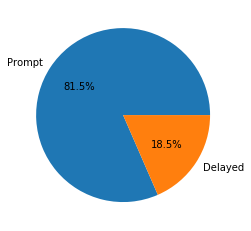

In [13]:
plt.pie(x=[df_TPC_prompt["Counts"].sum(), df_TPC_delayed["Counts"].sum()], autopct='%1.1f%%', labels=["Prompt", "Delayed"])
plt.savefig('./img/prompt-delayed.png')
plt.show()

# Total ratio of counts in TPC to buffer 

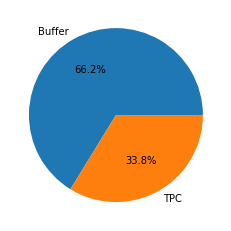

In [14]:
plt.pie(x=[df_buffers["Counts"].sum(), df_TPC_delayed["Counts"].sum() + df_TPC_prompt["Counts"].sum()], autopct='%1.1f%%', labels=["Buffer", "TPC"])
plt.show()

# Look for important unstable in buffer
Can't really do this - need another geant4 simulation

# Look for important unstable prompt isotopes in TPC
Isotopes that are produced inside the deadtime, but will live long enough to decay outside this time and emit a detectable signal

In [15]:
unstable_TPC_prompt.sort_values("Atomic Number", ascending=False).head(30)

,Iso Symbol,Atomic Number,Mass Number,Counts,Production Yield,Stable,Half Life (s),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Yield per Muon (/yr),BDecay 0-200 (keV)
154,Ca 20-39,20,39,1,1.257455e-08,False,0.860,"[[EC, 1.0, 6.533]]",6.533,red,0.03447,1e-08,False
164,K 19-42,19,42,41,5.155567e-07,False,44400.000,"[[B-, 1.0, 3.526]]",3.526,red,1.41327,4.1e-07,False
143,K 19-37,19,37,5,6.287277e-08,False,1.230,"[[EC, 1.0, 6.147]]",6.147,red,0.17235,5e-08,False
166,K 19-43,19,43,1,1.257455e-08,False,80300.000,"[[B-, 1.0, 1.815]]",1.815,red,0.03447,1e-08,True
137,K 19-36,19,36,3,3.772366e-08,False,0.342,"[[EC, 1.0, 12.805], [EP, 0.0005, 4.298], [EA, ...",12.805,red,0.10341,3e-08,False
148,K 19-38,19,38,180,2.263420e-06,False,458.000,"[[EC, 1.0, 5.914]]",5.914,red,6.2046,1.8e-06,False
125,Ar 18-34,18,34,23,2.892147e-07,False,0.845,"[[EC, 1.0, 6.063]]",6.063,red,0.79281,2.3e-07,False
160,Ar 18-41,18,41,95890,1.205774e-03,False,6580.000,"[[B-, 1.0, 2.492]]",2.492,red,3305.33,0.0009589,False
131,Ar 18-35,18,35,515,6.475895e-06,False,1.780,"[[EC, 1.0, 5.966]]",5.966,red,17.7521,5.15e-06,False
142,Ar 18-37,18,37,92041,1.157375e-03,False,3030000.000,"[[EC, 1.0, 0.814]]",0.814,red,3172.65,0.00092041,False


In [16]:
# Filter with halflife greater than deadtime (lasts long enough)
important_TPC_prompt = unstable_TPC_prompt[unstable_TPC_prompt["Half Life (s)"] > 20000000].sort_values("Production (/yr)", ascending=False).reset_index(drop=True)
# Filter with beta energy ranges
important_TPC_prompt = important_TPC_prompt[pd.isnull(important_TPC_prompt[beta_col_name]) | (important_TPC_prompt[beta_col_name] == True)]

print(f"Number of isotopes in range: {len(important_TPC_prompt)}")
print(f"Total Production (/yr): {important_TPC_prompt['Production (/yr)'].sum()}")
important_TPC_prompt

Number of isotopes in range: 0
Total Production (/yr): 0


,Iso Symbol,Atomic Number,Mass Number,Counts,Production Yield,Stable,Half Life (s),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Yield per Muon (/yr),BDecay 0-200 (keV)


# Look for important unstable delayed isotopes in TPC

## Any isotopes that beta decay

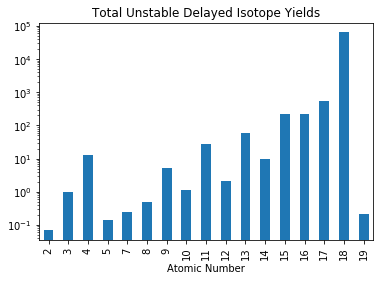

,Iso Symbol,Atomic Number,Mass Number,Counts,Production Yield,Stable,Half Life (s),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Yield per Muon (/yr),BDecay 0-200 (keV)
0,Ar 18-41,18,41,1793830,9.960547e-02,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red,61833.3,0.0179383,False
1,Ar 18-37,18,37,48543,2.695433e-03,False,3.030000e+06,"[[EC, 1.0, 0.814]]",0.814,red,1673.28,0.00048543,False
2,Cl 17-38,17,38,15151,8.412851e-04,False,2.230000e+03,"[[B-, 1.0, 4.916]]",4.916,red,522.255,0.00015151,False
3,S 16-35,16,35,5185,2.879060e-04,False,7.550000e+06,"[[B-, 1.0, 0.167]]",0.167,red,178.727,5.185e-05,True
4,P 15-32,15,32,4849,2.692490e-04,False,1.230000e+06,"[[B-, 1.0, 1.71]]",1.710,red,167.145,4.849e-05,False
5,Al 13-28,13,28,1534,8.517796e-05,False,1.340000e+02,"[[B-, 1.0, 4.642]]",4.642,red,52.877,1.534e-05,False
6,S 16-37,16,37,963,5.347222e-05,False,3.030000e+02,"[[B-, 1.0, 4.865]]",4.865,red,33.1946,9.63e-06,False
7,Na 11-24,11,24,773,4.292214e-05,False,5.400000e+04,"[[B-, 1.0, 5.515]]",5.515,red,26.6453,7.73e-06,False
8,P 15-34,15,34,617,3.425998e-05,False,1.240000e+01,"[[B-, 1.0, 5.374]]",5.374,red,21.268,6.17e-06,False
9,P 15-33,15,33,606,3.364918e-05,False,2.190000e+06,"[[B-, 1.0, 0.249]]",0.249,red,20.8888,6.06e-06,True


In [17]:
# All unstable that beta decay with decays per year > 1
unstable_TPC_delayed_beta = unstable_TPC_delayed.sort_values("Counts", ascending=False).reset_index(drop=True)
unstable_TPC_delayed_grouped = unstable_TPC_delayed_beta.groupby(['Atomic Number'])["Production (/yr)"].sum()
unstable_TPC_delayed_grouped.plot.bar(x="Atomic Number", log=True)
plt.title("Total Unstable Delayed Isotope Yields")
plt.show()
unstable_TPC_delayed_beta.head(70)

## Filter with high probability for beta emission in range

In [18]:
# Filter with beta energy ranges
important_TPC_delayed = unstable_TPC_delayed[pd.isnull(unstable_TPC_delayed[beta_col_name]) | (unstable_TPC_delayed[beta_col_name] == True)].sort_values("Counts", ascending=False).reset_index(drop=True)

print(f"Number of isotopes in range: {len(important_TPC_delayed)}")
print(f"Total Production (yr): {important_TPC_delayed['Production (/yr)'].sum()}\n")

print(f"Beta decays: {len(important_TPC_delayed[important_TPC_delayed[beta_col_name] == True])}")
print(f"Beta decay productions (/yr): {important_TPC_delayed.loc[important_TPC_delayed[beta_col_name] == True, 'Production (/yr)'].sum()}\n")

Number of isotopes in range: 5
Total Production (yr): 205.26885000000001

Beta decays: 4
Beta decay productions (/yr): 205.06203000000002



In [19]:
file_dir = f"./assets/{physic_model}/important_iso.csv"
important_TPC_delayed.to_csv(file_dir)
important_TPC_delayed

,Iso Symbol,Atomic Number,Mass Number,Counts,Production Yield,Stable,Half Life (s),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Yield per Muon (/yr),BDecay 0-200 (keV)
0,S 16-35,16,35,5185,2.879060e-04,False,7550000.00,"[[B-, 1.0, 0.167]]",0.167,red,178.727,5.185e-05,True
1,P 15-33,15,33,606,3.364918e-05,False,2190000.00,"[[B-, 1.0, 0.249]]",0.249,red,20.8888,6.06e-06,True
2,S 16-38,16,38,157,8.717692e-06,False,10200.00,"[[B-, 1.0, 2.937]]",2.937,red,5.41179,1.57e-06,True
3,Si 14-34,14,34,6,3.331602e-07,False,2.77,"[[B-, 1.0, 4.601]]",4.601,red,0.20682,6e-08,NaN
4,Mg 12-28,12,28,1,5.552670e-08,False,75300.00,"[[B-, 1.0, 1.832]]",1.832,red,0.03447,1e-08,True


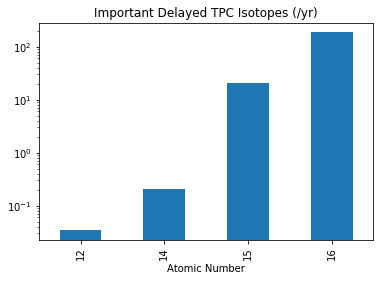

In [20]:
important_TPC_delayed_groups = important_TPC_delayed.groupby(['Atomic Number'])["Production (/yr)"].sum()
important_TPC_delayed_groups.plot.bar(x="Atomic Number", log=True)
plt.title("Important Delayed TPC Isotopes (/yr)")
plt.show()

# Combine df and convert to latex

In [43]:
important_combined = pd.concat([important_TPC_prompt.sort_values("Counts", ascending=False), important_TPC_delayed.sort_values("Counts", ascending=False), unstable_TPC_delayed_beta.sort_values("Counts", ascending=False)]).reset_index(drop=True)

def convert_iso(symbol):
    if symbol:
        name, nums = symbol.split(" ")
        num = nums.split("-")[1]
        return "$^{"+ str(num) + "}$" + str(name)

def convert_decays(decays):
    output = ""
    for decay in decays:
        if decay:
            if decay[0] == "B-":
                output = output + "$\beta$-,"
            elif decay[0] == "B+":
                output = output + "$\beta$+,"
            elif decay[0] == "A":
                output = output + "$\alpha$,"
            else:
                output = output + str(decay[0]) + ","
    return output[:-1]
important_combined["Iso Symbol"] = important_combined.apply(lambda x : convert_iso(x["Iso Symbol"]), axis = 1)
important_combined["Decay Modes (m, b, q MeV)"] = important_combined.apply(lambda x : convert_decays(x["Decay Modes (m, b, q MeV)"]), axis = 1)

important_combined = important_combined[["Iso Symbol", "Production (/yr)", "Yield per Muon (/yr)", "Half Life (s)", "Decay Modes (m, b, q MeV)"]]
important_combined['Production (/yr)'] = important_combined['Production (/yr)'].map('{:.3f}'.format)
important_combined['Production (/yr)'] = important_combined['Production (/yr)'].map(float)
important_combined["Yield per Muon (/yr)"] = important_combined["Yield per Muon (/yr)"].map("{:.2E}".format)
important_combined["Half Life (s)"] = important_combined["Half Life (s)"].map("{:.3E}".format)

print("Table Splitting (exclusive)")
print(f"Total: {len(important_combined)}")
if not len(important_TPC_prompt):
    print("TPC Prompt: None")
else:
    print(f"TPC Prompt: 0-{len(important_TPC_prompt)}")
print(f"TPC Delayed: {len(important_TPC_prompt)}-{len(important_TPC_prompt) + len(important_TPC_delayed)}")
print("Rest is all unstable in TPC")
print("\nSums:")
print(f"Sum Total: {important_combined['Production (/yr)'].sum()}")
print(f"Sum TPC: {important_combined.loc[0:len(important_TPC_prompt), 'Production (/yr)'].sum()}")
print(f"Sum Delayed: {important_combined.loc[len(important_TPC_prompt):len(important_TPC_prompt) + len(important_TPC_delayed), 'Production (/yr)'].sum()}")

Table Splitting (exclusive)
Total: 52
TPC Prompt: None
TPC Delayed: 0-5
Rest is all unstable in TPC

Sums:
Sum Total: 64806.422999999995
Sum TPC: 178.727
Sum Delayed: 62038.589


In [44]:
print("\n", important_combined.to_latex(escape=False))


 \begin{tabular}{llrlll}
\toprule
{} & Iso Symbol &  Production (/yr) & Yield per Muon (/yr) & Half Life (s) & Decay Modes (m, b, q MeV) \\
\midrule
0  &   $^{35}$S &           178.727 &             5.18E-05 &     7.550E+06 &                   eta$- \\
1  &   $^{33}$P &            20.889 &             6.06E-06 &     2.190E+06 &                   eta$- \\
2  &   $^{38}$S &             5.412 &             1.57E-06 &     1.020E+04 &                   eta$- \\
3  &  $^{34}$Si &             0.207 &             6.00E-08 &     2.770E+00 &                   eta$- \\
4  &  $^{28}$Mg &             0.034 &             1.00E-08 &     7.530E+04 &                   eta$- \\
5  &  $^{41}$Ar &         61833.320 &             1.79E-02 &     6.580E+03 &                   eta$- \\
6  &  $^{37}$Ar &          1673.277 &             4.85E-04 &     3.030E+06 &                        EC \\
7  &  $^{38}$Cl &           522.255 &             1.52E-04 &     2.230E+03 &                   eta$- \\
8  &   $^{35}$S 